# FewRel Dataset
Dataset downloaded from: https://github.com/thunlp/FewRel

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import re

from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import sent_tokenize
from tqdm import tqdm

import sys
sys.path.append("../../utils")
from dataset import preprocess_text, ireplace, dataset_stats

In [2]:
with open("raw/train_wiki.json") as f:
    train_data = json.load(f)

with open("raw/val_wiki.json") as f:
    val_data = json.load(f)
    
with open("raw/pid2name.json") as f:
    pid_dict = json.load(f)

# concatenate dicts
data = train_data | val_data

In [3]:
# wikidata relation type ids
data.keys()

dict_keys(['P931', 'P4552', 'P140', 'P1923', 'P150', 'P6', 'P27', 'P449', 'P1435', 'P175', 'P1344', 'P39', 'P527', 'P740', 'P706', 'P84', 'P495', 'P123', 'P57', 'P22', 'P178', 'P241', 'P403', 'P1411', 'P135', 'P991', 'P156', 'P176', 'P31', 'P1877', 'P102', 'P1408', 'P159', 'P3373', 'P1303', 'P17', 'P106', 'P551', 'P937', 'P355', 'P710', 'P137', 'P674', 'P466', 'P136', 'P306', 'P127', 'P400', 'P974', 'P1346', 'P460', 'P86', 'P118', 'P264', 'P750', 'P58', 'P3450', 'P105', 'P276', 'P101', 'P407', 'P1001', 'P800', 'P131', 'P177', 'P364', 'P2094', 'P361', 'P641', 'P59', 'P413', 'P206', 'P412', 'P155', 'P26', 'P410', 'P25', 'P463', 'P40', 'P921'])

In [4]:
print(f"num relations train: {len(train_data.keys())}")
print(f"num relations val: {len(val_data.keys())}")
print(f"num common relation: {len(set(val_data.keys()) & set(train_data.keys()))}")

num relations train: 64
num relations val: 16
num common relation: 0


In [5]:
pid_dict["P931"]

['place served by transport hub',
 'territorial entity or entities served by this transport hub (airport, train station, etc.)']

In [6]:
data["P931"][0]

{'tokens': ['Merpati',
  'flight',
  '106',
  'departed',
  'Jakarta',
  '(',
  'CGK',
  ')',
  'on',
  'a',
  'domestic',
  'flight',
  'to',
  'Tanjung',
  'Pandan',
  '(',
  'TJQ',
  ')',
  '.'],
 'h': ['tjq', 'Q1331049', [[16]]],
 't': ['tanjung pandan', 'Q3056359', [[13, 14]]]}

In [7]:
# problem: sentence is already tokenized
tokenized_text = data["P931"][2]["tokens"]
print(TreebankWordDetokenizer().detokenize(tokenized_text))
print("vs.")
print(" ".join(tokenized_text))
print("vs.")
print(preprocess_text(tokenized_text))

It is a four - level stack interchange near Fort Lauderdale - Hollywood International Airport in Fort Lauderdale, Florida.
vs.
It is a four - level stack interchange near Fort Lauderdale - Hollywood International Airport in Fort Lauderdale , Florida .
vs.
It is a four-level stack interchange near Fort Lauderdale-Hollywood International Airport in Fort Lauderdale, Florida.


In [8]:
# convert dataset to dataframe with necessary info
samples = []
for pid in tqdm(data):
    for x in data[pid]:
        t_before_h = x["h"][2][0][-1] > x["t"][2][0][0] # check if h appears before t in text appears before h in text
        d = {
            "full_text": preprocess_text(x["tokens"]),
            "h": preprocess_text([x["tokens"][i] for i in x["h"][2][0]]), # extract from tokens, x["h"] already lowercase
            "h_id": x["h"][1],
            "r": pid_dict[pid][0],
            "r_id": pid,
            "t": preprocess_text([x["tokens"][i] for i in x["t"][2][0]]),
            "t_id": x["t"][1],
            "t_before_h": t_before_h,
            #cut full text right before head or tail entity depending on t_before_h
            "prompt": preprocess_text(x["tokens"][:x["t"][2][0][0]]) if not t_before_h 
                else preprocess_text(x["tokens"][:x["h"][2][0][0]])
        }
        samples.append(d)
df = pd.DataFrame(samples)
df = df.reset_index(names="id") # add id to each sample

100%|██████████| 80/80 [00:14<00:00,  5.70it/s]


In [9]:
df.head()

,id,full_text,h,h_id,r,r_id,t,t_id,t_before_h,prompt
0,0,Merpati flight 106 departed Jakarta on a domes...,TJQ,Q1331049,place served by transport hub,P931,Tanjung Pandan,Q3056359,True,Merpati flight 106 departed Jakarta on a domes...
1,1,The name was at one point changed to Nottingha...,East Midlands Airport,Q8977,place served by transport hub,P931,Nottingham,Q41262,True,The name was at one point changed to Nottingham
2,2,It is a four-level stack interchange near Fort...,Fort Lauderdale-Hollywood International Airport,Q635361,place served by transport hub,P931,"Fort Lauderdale, Florida",Q165972,False,It is a four-level stack interchange near Fort...
3,3,It is the main alternate of Jinnah Internation...,Jinnah International Airport,Q61052,place served by transport hub,P931,Karachi,Q8660,False,It is the main alternate of Jinnah Internation...
4,4,Nearby airports include Akwa Ibom Airport at O...,Margaret Ekpo International Airport,Q1030578,place served by transport hub,P931,Calabar,Q844091,False,Nearby airports include Akwa Ibom Airport at O...


Unique relations: 80
Num samples: 56000


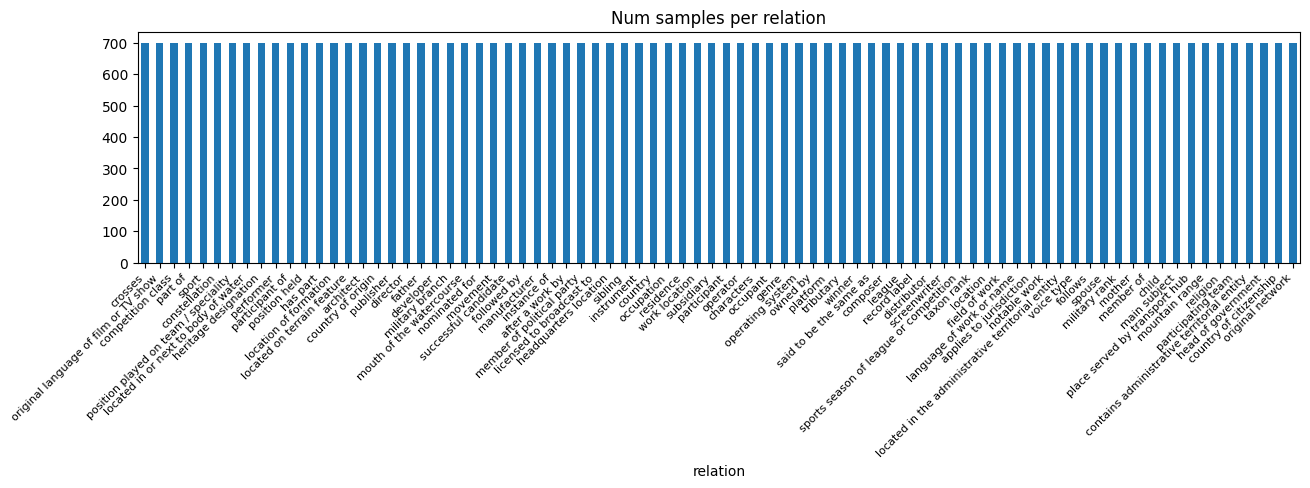

In [10]:
dataset_stats(df)

In [11]:
# add retrieved wikidata entity labels
df_wikidata = pd.read_json("../wikidata_entity_data.json", lines=True)
df_wikidata.head()

,id,label,description,aliases
0,Q5,human,"any member of Homo sapiens, unique extant spec...","[people, man, men, human being, humans, indivi..."
1,Q15,Africa,continent,"[African continent, Ancient Libya]"
2,Q16,Canada,country in North America,"[CA, CAN]"
3,Q18,South America,continent,None
4,Q20,Norway,country in Northern Europe,"[NO, 🇳🇴, NOR, Kingdom of Norway]"


In [12]:
df = df.merge(df_wikidata.rename(columns={"id": "h_id", "label": "h_retrieved"})[["h_id", "h_retrieved"]])
df = df.merge(df_wikidata.rename(columns={"id": "t_id", "label": "t_retrieved"})[["t_id", "t_retrieved"]])

In [13]:
# filter data
# - retrieved entity is not NA
# - full_text starts with prompt
# - t/h is exactly mentioned once in prompt depending on t_before_h
# - t/h is exactly mentioned once in full_text w/o prompt depending on t_before_h
# - prompt has less than n words (not enough context for completion)
# - prompt has more than n words

In [14]:
print(f"Num of head entity ids not found in wikidata: {df['h_retrieved'].isna().sum()}")
print(f"Num of tail entity ids not found in wikidata: {df['t_retrieved'].isna().sum()}")
# drop rows with retrieved entities which are NA
df = df[~df["h_retrieved"].isna()]
df = df[~df["t_retrieved"].isna()]

Num of head entity ids not found in wikidata: 201
Num of tail entity ids not found in wikidata: 143


In [15]:
# full_text does not start with prompt
sum(~df.apply(lambda row: row["full_text"].startswith(row["prompt"]), axis=1))

2003

In [16]:
df[~df.apply(lambda row: row["full_text"].startswith(row["prompt"]), axis=1)][["full_text", "prompt"]].head(5)

,full_text,prompt
0,Merpati flight 106 departed Jakarta on a domes...,Merpati flight 106 departed Jakarta on a domes...
29,László Nagy was a Hungarian poet and translator.,László Nagy (17 July 1925 in Felsőiszkáz-30 Ja...
33,"Zsolt Wintermantel is a Hungarian politician, ...","Zsolt Wintermantel is a Hungarian politician, ..."
37,György Matolcsy is a Hungarian politician and ...,"György Matolcsy (born 18 July 1955,"
53,"2-30 days, also available at Gurney Airport an...","2-30 days, also available at Gurney Airport ("


In [17]:
# keep only rows where full_text starts with prompt
df = df[df.apply(lambda row: row["full_text"].startswith(row["prompt"]), axis=1)]

In [18]:
# relevant entity appears multiple times or appears not in prompt
len(df[df.apply(lambda row: row["prompt"].lower().count(row["h"].lower()) 
                if not row["t_before_h"] else row["prompt"].lower().count(row["t"].lower()), axis=1) != 1])

1244

In [19]:
# keep only rows where relevent entity appears exactly once in prompt
df = df[df.apply(lambda row: row["prompt"].lower().count(row["h"].lower()) 
                 if not row["t_before_h"] else row["prompt"].lower().count(row["t"].lower()), axis=1) == 1]

In [20]:
# relevant entity appears multiple times or appears not in full_text without prompt
len(df[df.apply(lambda row: row["full_text"][len(row["prompt"]):].lower().count(row["t"].lower()) 
                if not row["t_before_h"] else row["full_text"][len(row["prompt"]):].lower().count(row["h"].lower()), axis=1) != 1])

465

In [21]:
# keep only rows where relevent entity appears exactly once in full_text without prompt
df = df[df.apply(lambda row: row["full_text"][len(row["prompt"]):].lower().count(row["t"].lower()) 
                 if not row["t_before_h"] else row["full_text"][len(row["prompt"]):].lower().count(row["h"].lower()), axis=1) == 1]

In [22]:
# relevant for pipeline setup
# problem: some samples consist of multiple sentences or are split by sent_tokenize into multiple sentences
# we only want to generate the completion of one sentence
len(df[df["full_text"].apply(lambda x: len(sent_tokenize(x))) != 1])

723

In [23]:
# keep only rows with one sentence
df = df[df["full_text"].apply(lambda x: len(sent_tokenize(x))) == 1]

In [24]:
# rows where prompt has less than n words
n = 3
len(df[df["prompt"].apply(lambda x: len(x.split())) < n])

535

In [25]:
# keep rows where prompt has at least n words
df = df[df["prompt"].apply(lambda x: len(x.split())) >= n]

In [26]:
# rows where prompt has more than n words
n = 30
len(df[df["prompt"].apply(lambda x: len(x.split())) > n])

89

In [27]:
# keep rows where prompt has at least n words
df = df[df["prompt"].apply(lambda x: len(x.split())) <= n]

In [28]:
# add counterfactual data
# dict with all head and tail entities per relation
entity_dict = {}
for r_id, group in df.groupby("r_id"):
    entity_dict[r_id] = {
        "h": group[["h_id", "h", "h_retrieved"]].drop_duplicates(subset="h_id").set_index("h_id", drop=True).to_dict(orient="index"),
        "t": group[["t_id", "t", "t_retrieved"]].drop_duplicates(subset="t_id").set_index("t_id", drop=True).to_dict(orient="index")
    }

In [29]:
def sample_entity(row):
    entity_type = "h" if row["t_before_h"] else "t" # entity type to sample
    entity_dict_r = entity_dict[row["r_id"]][entity_type]
    ids = list(entity_dict_r.keys())
    ids.remove(row[entity_type + "_id"])
    sample_id = random.choice(ids)
    sample_list = list(entity_dict_r[sample_id].values())
    return pd.Series({
        "id": row["id"], 
        "cf_id": sample_id, 
        "cf_entity": sample_list[1], # retrieved entity
        "cf_entity_type": entity_type
    })

In [30]:
# create dataframe with counterfactual entities
df_cf = df.apply(lambda row: sample_entity(row), axis=1)
df_cf.head()

,id,cf_id,cf_entity,cf_entity_type
1,1,Q1043631,Murtala Muhammed International Airport,h
2,9586,Q7229560,Poppy & the Jezebels,h
3,22733,Q1435,Zagreb,t
4,40922,Q3579,Tripoli,t
5,2,Q649,Moscow,t


In [31]:
# add counterfactual data to dataframe
df = df.merge(df_cf).sort_values("id")

In [32]:
# replace mention of entity in full_text with counterfactual entity
df["cf_full_text"] = df.apply(lambda row: ireplace(
    row["full_text"], row["h"] if row["t_before_h"] else row["t"], row["cf_entity"]
    ), axis=1)

In [33]:
df["cf_full_text"] = df.apply(
    lambda row: row["full_text"].replace(row["h"] if row["t_before_h"] else row["t"], row["cf_entity"]), 
    axis=1
)

In [34]:
# drop samples where cf_entity is in full_text
print(df.apply(lambda row: row["cf_entity"].lower() in row["full_text"].lower(), axis=1).sum())
df = df[~df.apply(lambda row: row["cf_entity"].lower() in row["full_text"].lower(), axis=1)]

73


In [35]:
df.head()

,id,full_text,h,h_id,r,r_id,t,t_id,t_before_h,prompt,h_retrieved,t_retrieved,cf_id,cf_entity,cf_entity_type,cf_full_text
0,1,The name was at one point changed to Nottingha...,East Midlands Airport,Q8977,place served by transport hub,P931,Nottingham,Q41262,True,The name was at one point changed to Nottingham,East Midlands Airport,Nottingham,Q1043631,Murtala Muhammed International Airport,h,The name was at one point changed to Nottingha...
4,2,It is a four-level stack interchange near Fort...,Fort Lauderdale-Hollywood International Airport,Q635361,place served by transport hub,P931,"Fort Lauderdale, Florida",Q165972,False,It is a four-level stack interchange near Fort...,Fort Lauderdale–Hollywood International Airport,Fort Lauderdale,Q649,Moscow,t,It is a four-level stack interchange near Fort...
5,3,It is the main alternate of Jinnah Internation...,Jinnah International Airport,Q61052,place served by transport hub,P931,Karachi,Q8660,False,It is the main alternate of Jinnah Internation...,Jinnah International Airport,Karachi,Q3844,Brazzaville,t,It is the main alternate of Jinnah Internation...
10,4,Nearby airports include Akwa Ibom Airport at O...,Margaret Ekpo International Airport,Q1030578,place served by transport hub,P931,Calabar,Q844091,False,Nearby airports include Akwa Ibom Airport at O...,Margaret Ekpo International Airport,Calabar,Q598,Rzeszów,t,Nearby airports include Akwa Ibom Airport at O...
11,5,"Pakyong Airport, a Greenfield project, is unde...",Pakyong Airport,Q7126092,place served by transport hub,P931,Gangtok,Q186141,False,"Pakyong Airport, a Greenfield project, is unde...",Pakyong Airport,Gangtok,Q56126,Río Bueno,t,"Pakyong Airport, a Greenfield project, is unde..."


Unique relations: 80
Num samples: 50525


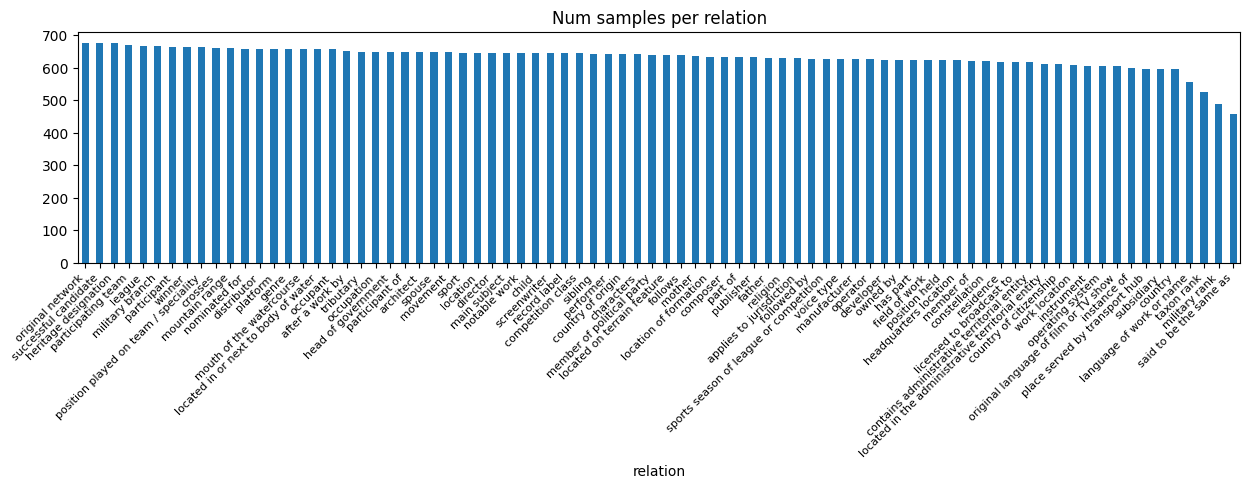

In [36]:
dataset_stats(df)

In [37]:
df.to_json("fewrel_preprocessed.json", orient="records", lines=True)

In [38]:
# validation dataset
# n examples per relation type
n = 25
df_val = df.groupby("r").head(n).sort_values("id")

Unique relations: 80
Num samples: 2000


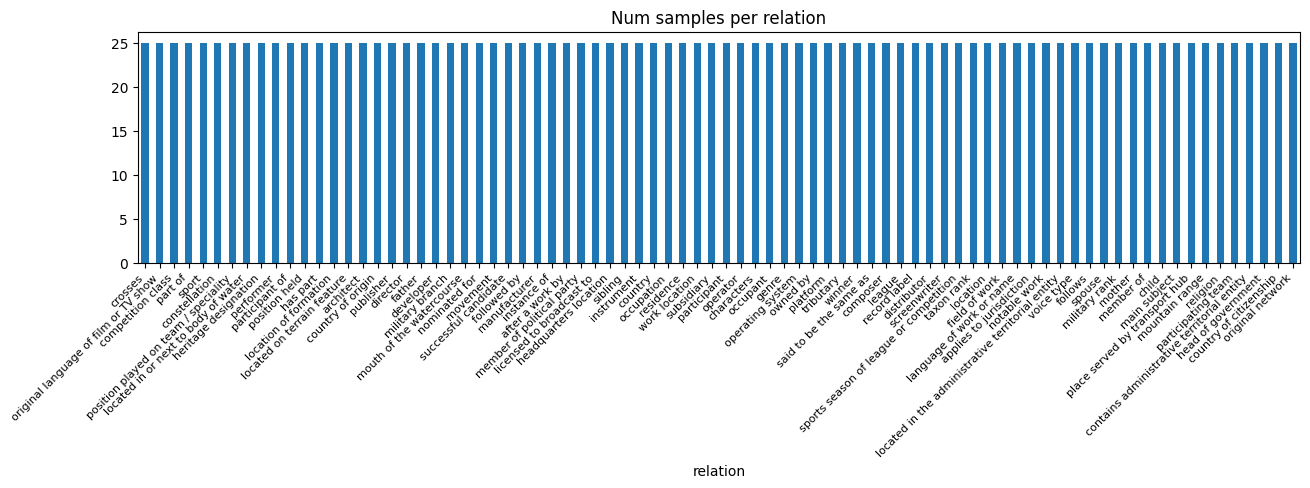

In [39]:
dataset_stats(df_val)

In [40]:
df_val.to_json("fewrel_val.json", orient="records", lines=True)

In [41]:
# dev set for developing metrics and metric eval
# n examples per relation type
n = 25
# df without df_val
df_subset = df[df["id"].apply(lambda x: x not in df_val["id"].to_list())].sort_values("id")
df_dev = df_subset.groupby("r").head(n).sort_values("id")

Unique relations: 80
Num samples: 2000


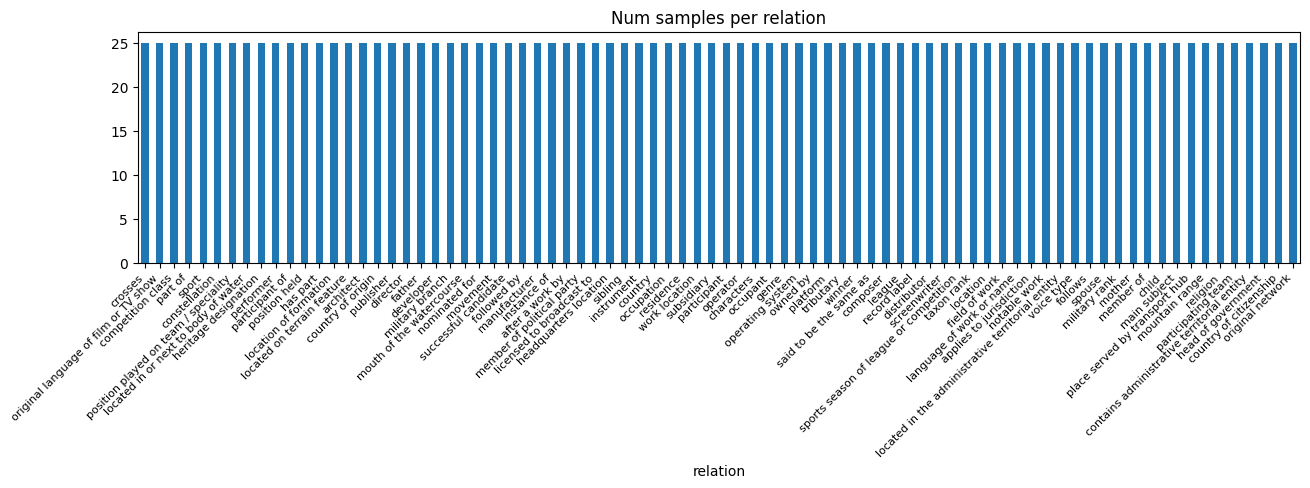

In [42]:
dataset_stats(df_dev)

In [43]:
df_dev.to_json("fewrel_dev.json", orient="records", lines=True)